# EEG preprocessing 

In this notebook: 
- Necessary imports
- Data loader for events, eeg and meta data
- Filtering algorithm
- EEG raw to epochs
- Epochs to evoked responses (ERPs)
- Averaging code for ERPS
- Grand average 
- Mismatch response
- saving filtered data

Preprocessing steps: 
+ Prepare EEG (1. Subtract reference (mastoids), 2. Detrend, 3. Filter, 4. Remove bad channels)
+ Segment EEG into standard and deviant epochs (ERPs) (1. subtract baseline, 2. Reject artefacts, 3. Average (for each marker/subject/channel separately))
+ Calculate Mismatch response (deviant - standard for a single subject) (check differences between channels and subjects)

## Imports

The data will be processed using the mne library. Also there are libraries made in eegyolk in order to load the metadata, eeg data and the event markers. Those libraries need to be imported

In [1]:
import mne      # toolbox for analyzing and visualizing EEG data
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
from ipywidgets import IntSlider, Output
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from math import nan

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
import initialization_functions #library to import data
import epod_helper

<font color='blue'>Review block: you should strive to make the local import  of eegyolk unneccisary. When we release next version, make sure it runs with just 'import eegyolk' instead the of the sys.path.insert trick</font>

## Load metadata and eeg files

First the different pathways for the different datasets need to be defined. There are three pathways: eeg, metadata and events. The files can be loaded using the initialization_functions library. All event markers needs to be saved in a seperate folder. If not saved already, the event markers will be saved using the initialization_function library. The data must be saved in a separate folder called "epod_data_not_pushed" in the ePodium repository. 

In [2]:
pwd

'/home/cmoore/eegyolk/dyslexiaprediction_nadine'

In [3]:
data_path = "../../volume-ceph/ePodium_projectfolder"
#data_path = "F:\Stage\ePODIUM\Data\ePodium_projectfolder"
path_eeg = os.path.join(data_path, "Dataset")
path_metadata = os.path.join(data_path, "metadata")
path_eventmarkers = os.path.join(data_path, "events")

<font color='blue'>Review block: you should checkout eegyolk.config module. Read it and see how I made this dance around paths unnecsary</font>

In [4]:
# load metadata
files_metadata = ["children.txt", "cdi.txt", "parents.txt", "CODES_overview.txt"]  
children, cdi, parents, codes = initialization_functions.i_load_metadata(path_metadata, files_metadata)

<font color='blue'>Review block: In the cell below I would suggest making the output optional (low priority)...It isn't neccesarily interesting for everyone at all times</font>

In [5]:
# load eeg

eeg, eeg_filename =  initialization_functions.load_dataset(path_eeg, preload=False); 
# preload must be set to True once on the cloud

Extracting EDF parameters from /home/cmoore/volume-ceph/ePodium_projectfolder/Dataset/105a.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
1 EEG files loaded
Extracting EDF parameters from /home/cmoore/volume-ceph/ePodium_projectfolder/Dataset/105b.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
2 EEG files loaded
Extracting EDF parameters from /home/cmoore/volume-ceph/ePodium_projectfolder/Dataset/107a.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
3 EEG files loaded
Extracting EDF parameters from /home/cmoore/volume-ceph/ePodium_projectfolder/Dataset/106a.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
4 EEG files loaded
Extracting EDF parameters from /home/cmoore/volume-ceph/ePodium_projectfolder/Dataset/106b.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
5 EEG files loaded


/home/cmoore/eegyolk/dyslexiaprediction_nadine/../eegyolk/initialization_functions.py:55: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(path, preload=preload)
/home/cmoore/eegyolk/dyslexiaprediction_nadine/../eegyolk/initialization_functions.py:55: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(path, preload=preload)


Setting channel info structure...
Creating raw.info structure...
35 EEG files loaded
Extracting EDF parameters from /home/cmoore/volume-ceph/ePodium_projectfolder/Dataset/121b(1).bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
36 EEG files loaded
Extracting EDF parameters from /home/cmoore/volume-ceph/ePodium_projectfolder/Dataset/122a.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
37 EEG files loaded
Extracting EDF parameters from /home/cmoore/volume-ceph/ePodium_projectfolder/Dataset/126b.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
38 EEG files loaded
Extracting EDF parameters from /home/cmoore/volume-ceph/ePodium_projectfolder/Dataset/124a.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
39 EEG files loaded
Extracting EDF parameters from /home/cmoore/volume-ceph/ePodium_projectfolder/Dataset/125b.bdf...
BDF file d

/home/cmoore/eegyolk/dyslexiaprediction_nadine/../eegyolk/initialization_functions.py:55: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_bdf(path, preload=preload)


175 EEG files loaded
Extracting EDF parameters from /home/cmoore/volume-ceph/ePodium_projectfolder/Dataset/196a.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
176 EEG files loaded
Extracting EDF parameters from /home/cmoore/volume-ceph/ePodium_projectfolder/Dataset/198a.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
177 EEG files loaded
Extracting EDF parameters from /home/cmoore/volume-ceph/ePodium_projectfolder/Dataset/199a.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
178 EEG files loaded
Extracting EDF parameters from /home/cmoore/volume-ceph/ePodium_projectfolder/Dataset/200b.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
179 EEG files loaded
Extracting EDF parameters from /home/cmoore/volume-ceph/ePodium_projectfolder/Dataset/180a.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info str

In [6]:
# load events 
events_files = os.listdir(path_eventmarkers)
if len(events_files) == 0 or path_eventmarkers == False: # check if event markers are saved in a seperate folder
    initialization_functions.save_event_markers(path_eventmarkers, eeg, eeg_filename) # save event markers

event_markers = initialization_functions.load_events(path_eventmarkers, eeg_filename) # load event markers
event_markers_simplified = epod_helper.group_events_12(event_markers) # simplify events

206 Event Marker files loaded


In [7]:
len(event_markers_simplified)

206

## Data info

Choose which participant you want to view in the box below. 

In [8]:
index = widgets.IntText(
    step=0.1,
    description='Participant',
    disabled=False
)
widgets.VBox([index])

In [9]:
index = int(index.value)

Using matplotlib as 2D backend.
Opening raw-browser...


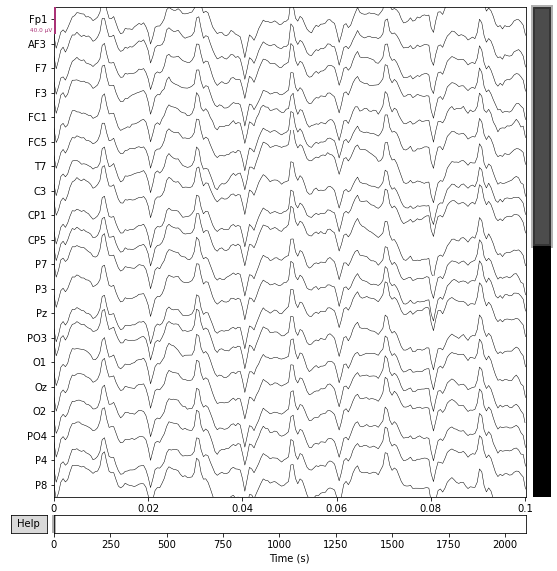

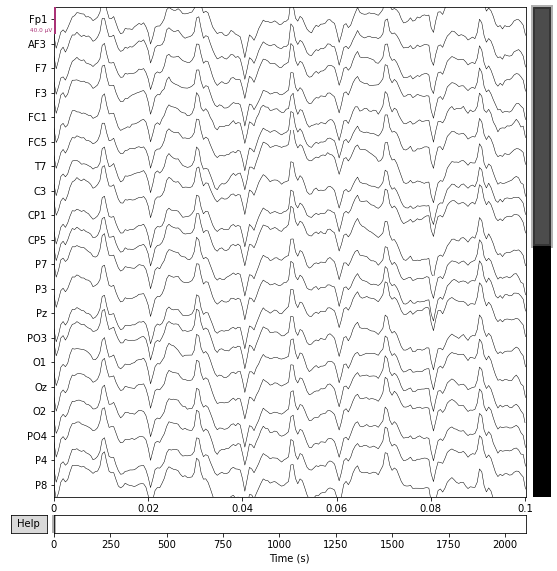

In [10]:
eeg[index].plot(duration=0.1)

/tmp/ipykernel_425960/29831197.py:2: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  fig = mne.viz.plot_events(event_markers_simplified[index], event_id = epod_helper.event_dictionary)


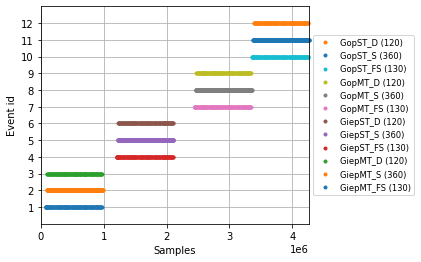

In [11]:
%matplotlib inline 
fig = mne.viz.plot_events(event_markers_simplified[index], event_id = epod_helper.event_dictionary)

## Filtering raw EEG 

Below you can define the frequencies for the bandpass filter. The lowpass can not be below 0 and the highpass can not be higher then 100. Most common bandpass filter is filtering between 0.1 and 30. 

In [12]:
lowpass = widgets.BoundedFloatText(
    value=0.1,
    min=0,
    max=100,
    step=0.1,
    description='lowpass:',
    disabled=False
)

highpass = widgets.BoundedFloatText(
    value=30,
    min=0,
    max=100,
    step=0.1,
    description='highpass:',
    disabled=False
)

widgets.VBox([lowpass,highpass])


In [13]:
# change type to integer
lowpass = float(lowpass.value)
highpass = float(highpass.value)

The number of freqs can vary and be adjusted by changing `n`. The used frequency for this analysis is `[60, 120, 180, 240]`.

See the below to preset your values in a better way, your old way now commented out

In [1]:
n = 4
freq = list(widgets.BoundedIntText(
    description='freq[{}]'.format(i),
    min=0,
    max=300,
    step=1,
    value=(i+1)*60)
    for i in range(n))

widgets.VBox(children=freq)

NameError: name 'widgets' is not defined

<font color='blue'>Review block: You might be able to  rewrite and reformat that, see above for reformatting, and to be extra efficcient, see if you can skip using list and use brackets maybe?</font>

In [15]:
# n = 4
# seed = np.zeros(n)
# freq = list(widgets.BoundedIntText(
#               description = 'freq[{}]'.format(i),
#               min = 0, 
#               max = 300, 
#               step = 1, 
#               value = seed[i]) 
#           for i in range(n))

# widgets.VBox(children = freq)

In [16]:
freqs = []
for i in range(len(freq)): freqs.append(freq[i].value)

<font color='blue'>Review block: take a look at the code below for a different more 'programmer way to approach this maybe'. Admittedly I didn't wait for it to run, but try it, or something like it. It's a valid alternative, and do as I say, not as I do ;)</font>

In [ ]:
freqs= [f.value for f in freq]

Epochs are created with joining the eeg data with a specific event.  mne.Epochs automaticaly create a baseline correction and artefact rejection. 

In [17]:
event_dictionary = epod_helper.event_dictionary
event_dictionary

{'GiepMT_FS': 1,
 'GiepMT_S': 2,
 'GiepMT_D': 3,
 'GiepST_FS': 4,
 'GiepST_S': 5,
 'GiepST_D': 6,
 'GopMT_FS': 7,
 'GopMT_S': 8,
 'GopMT_D': 9,
 'GopST_FS': 10,
 'GopST_S': 11,
 'GopST_D': 12}

In order to create the epochs, the time before `tmin` and after an event `tmax` needs to be defined. The default values are set to -0.3 and 0.7. `tmin` and `tmax` are the start and stop time relative to each event.

In [18]:
tmin = widgets.BoundedFloatText(
    value=-0.3,
    min=-1,
    max=1,
    step=0.1,
    description='tmin:',
    disabled=False
)

tmax = widgets.BoundedFloatText(
    value=0.7,
    min=-1,
    max=1,
    step=0.1,
    description='tmax:',
    disabled=False
)

widgets.VBox([tmin,tmax])

In [19]:
tmin = float(tmin.value)
tmax = float(tmax.value)

This filter contains a bandpass filter, with as input the parameters `lowpass` and `highpass`. It also contains a notch filter to filter out power line noise and needs as input `freqs` for frequencies to apply the notch filter on. The next input is `mastoid_channels`, to subtract the reference from the raw eeg data. Finally, channels from the eeg can be dropped by adjusting the `drop_ch`. 

For a selected event, an interval is created with a time before and after event. This represents an epoch. The function automatically performs a baseline correction. 

In [20]:
mastoid_channels = ['EXG1', 'EXG2']
drop_ch = ['EXG1', 'EXG2','EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status']

def filter_raweeg_gen(eeg, lowpass, highpass, freqs, mastoid_channels, drop_ch):
    for i in range(len(eeg)): 
        processed_file = os.path.join(epoch_folder, eeg_filename[i]+"_epo.fif")
        if not os.path.exists(processed_file):
            yield hf.filter_eeg_raw(eeg[i].load_data(), lowpass, highpass, freqs, mastoid_channels, drop_ch)
        else: 
            yield print(f"File {processed_file} already processed \n", end = '')
            

The cell below  breaks my kernel. After fidding with memoryit breaksafter around 20 instead of 2. No idea why. I was so confused as to why this happens I gpt my husband to look at it. He has no idea ether, and says on the surface it seems like it should be fine.

In [21]:
filtered_eegs = filter_raweeg_gen(eeg, lowpass, highpass, freqs, mastoid_channels, drop_ch)
#epoch_folder = os.path.join( "../../volume-ceph/processed/", "epochs")
epoch_folder = os.path.join(data_path, "epochs")
if not os.path.exists(epoch_folder):
        os.mkdir(epoch_folder)
        
for idx, single_eeg in enumerate(filtered_eegs):
    processed_file = os.path.join(epoch_folder, eeg_filename[idx]+"_epo.fif")
    if not os.path.exists(processed_file):
        epoch = hf.create_epoch(single_eeg, event_markers_simplified[idx], tmin, tmax)
        epoch_file = os.path.join(epoch_folder, eeg_filename[idx]+"_epo.fif")
        epoch.save(epoch_file, overwrite=True)
        print("\n", idx+1, " saved.")


File ../../volume-ceph/ePodium_projectfolder/epochs/105a_epo.fif already processed 
File ../../volume-ceph/ePodium_projectfolder/epochs/105b_epo.fif already processed 
File ../../volume-ceph/ePodium_projectfolder/epochs/107a_epo.fif already processed 
File ../../volume-ceph/ePodium_projectfolder/epochs/106a_epo.fif already processed 
File ../../volume-ceph/ePodium_projectfolder/epochs/106b_epo.fif already processed 
File ../../volume-ceph/ePodium_projectfolder/epochs/107b (deel 1+2)_epo.fif already processed 
File ../../volume-ceph/ePodium_projectfolder/epochs/109b_epo.fif already processed 
File ../../volume-ceph/ePodium_projectfolder/epochs/109a_epo.fif already processed 
File ../../volume-ceph/ePodium_projectfolder/epochs/107b (deel 3+4)_epo.fif already processed 
File ../../volume-ceph/ePodium_projectfolder/epochs/108a_epo.fif already processed 
File ../../volume-ceph/ePodium_projectfolder/epochs/110a_epo.fif already processed 
File ../../volume-ceph/ePodium_projectfolder/epochs/11

<font color='blue'>Review block: Super technical but important note: os.path.isfile() is better than exists(). exists() will return true even if you put in a directory, not a file. Also, this block is complicated, and if we have time, I'd like to sit on it more and refactor.</font>

## Create ERPS

Evoked responses are created by averaging the epochs for a specific event. The function therefore needs as input the created `epochs` and `event_dictionary` containing the different types of events used in the experiment. 

In [22]:
evoked = hf.evoked_responses(epoch, event_dictionary)

## ERP visualizations for a single subject

In [23]:
eeg[5].plot_sensors(ch_type='eeg', show_names=True)

RuntimeError: No valid channel positions found

Below each event is plotted for a single subject with the average for each channel. 

In [ ]:
for i in range(len(event_dictionary)):
    evoked[i].plot(spatial_colors=True, exclude='bads')
    print(([key for key in epod_helper.event_dictionary.keys()][i], [value for value in epod_helper.event_dictionary.values()][i]))

<font color='blue'>Review block: I think you may have wanted something else here, not sure but did you try the below:</font>

In [ ]:
print((k,v for j,(k,v) in enumerate(event_dictionary.items()) if j ===i))

<font color='blue'>Or something along those lines ;)</font>

The grand average is calculated by the average response on all events combined for each channel. 

In [ ]:
ga_singlesub = mne.grand_average(evoked)
ga_singlesub.plot(spatial_colors=True)

We will now only look at the standard events, which are events 2, 5, 8 and 11. The first standards were removed, since the participant need some time to adjust to the standard not being 'new' anymore. The deviant events differ from the standard one and are 3, 6, 9 and 12. First, the average per channel for the standard and deviant is calculated and plotted. The second plots shows the mean over all channels between the standard and deviant. 

In [ ]:
std_evoked = epoch[2, 5, 8, 11].average()
dev_evoked = epoch[3, 6, 9, 12].average()

<font color='blue'>Fix your formatting (as I did above), these tiny, minute details will make your improving code look more professional, and let others know you know what you are doing ;) I see great improvement, let it shine!</font>

In [ ]:
std_evoked

In [ ]:
evoked_diff = mne.combine_evoked([std_evoked, dev_evoked], weights=[1, -1])

In [ ]:
chnames = evoked_diff.info['ch_names']

chnames = mne.pick_channels(evoked_diff.info['ch_names'], include=chnames)

roi_dict = dict(left_ROI=chnames)
roi_evoked = mne.channels.combine_channels(evoked_diff, roi_dict, method='mean')
roi_evoked.plot()


In [ ]:
chnames = evoked_diff.info['ch_names']
chnames_dev = dev_evoked.info['ch_names']

chnames_std = mne.pick_channels(std_evoked.info['ch_names'], include=chnames)
chnames_dev = mne.pick_channels(dev_evoked.info['ch_names'], include=chnames_dev)

roi_dict = dict(left_ROI=chnames_std)
roi_evoked_dev = mne.channels.combine_channels(dev_evoked, roi_dict, method='mean')
print("Deviant") 
roi_evoked_dev.plot()
roi_evoked_std = mne.channels.combine_channels(std_evoked, roi_dict, method='mean')
print("Standard")
roi_evoked_std.plot()
evoked_diff = mne.combine_evoked([roi_evoked_std, roi_evoked_dev], weights=[1, -1])
print("mismatch response")
evoked_diff.plot()

In [ ]:
evokeds = dict(standard=std_evoked, deviant=dev_evoked)
mne.viz.plot_compare_evokeds(evokeds, combine='mean')

## Create DataFrame with metadata and eeg/epoch paths

In [ ]:
parents.rename(columns = {'child':'ParticipantID'}, inplace=True)
cdi.rename(columns = {'participant':'ParticipantID'}, inplace=True)

In [ ]:
metadata = pd.merge(cdi, children, on="ParticipantID")
metadata = pd.merge(metadata, parents, on="ParticipantID")

In [ ]:
metadata = metadata.drop(['b01 - Geluidseffecten en dierengeluiden',
       'b02 - Dierennamen', 'b03 - Voertuigen', 'b04 - Speelgoed',
       'b05 - Eten en drinken', 'b06 - Kleding', 'b07 - Delen van het lichaam',
       'b08 - Kleine huishoudelijke voorwerpen', 'b09 - Meubels en kamers',
       'b10 - Voorwerpen buitenshuis', 'b11 - Plaatsen buitenshuis',
       'b12 - Mensen', 'b13 - Spelletjes en routines',
       'b14 - Omschrijvende woorden', 'b15 - Werkwoorden',
       'b16 - Woorden over tijd', 'b17 - Voornaamwoorden',
       'b18 - Vragende woordjes', 'b19 - Voorzetsels en plaatsbepalingen',
       'b20 - Hoeveelheden en lidwoorden', 'b21 - Hulpwerkwoorden',
       'b22 - Voegwoorden', 'p01 - Geluidseffecten en dierengeluiden',
       'p02 - Dierennamen', 'p03 - Voertuigen', 'p04 - Speelgoed',
       'p05 - Eten en drinken', 'p06 - Kleding', 'p07 - Delen van het lichaam',
       'p08 - Kleine huishoudelijke voorwerpen', 'p09 - Meubels en kamers',
       'p10 - Voorwerpen buitenshuis', 'p11 - Plaatsen buitenshuis',
       'p12 - Mensen', 'p13 - Spelletjes en routines',
       'p14 - Omschrijvende woorden', 'p15 - Werkwoorden',
       'p16 - Woorden over tijd', 'p17 - Voornaamwoorden',
       'p18 - Vragende woordjes', 'p19 - Voorzetsels en plaatsbepalingen',
       'p20 - Hoeveelheden en lidwoorden', 'p21 - Hulpwerkwoorden',
       'p22 - Voegwoorden', 'wB - Woorduiteinden', 'wC - Woordvormen',
       'zE - Zinnen',  'Woordvormen - Ruwe score', 'Woordvormen - Percentiel',
       'Woordvormen - Taalleeftijd', 'Zinnen - Ruwe score',
       'Zinnen - Percentiel', 'Zinnen - Taalleeftijd', 'VocabularyComprehension_Raw',
       'VocabularyComprehension_Percentile',
       'VocabularyComprehension_LanguageAge', 'VocabularyProduction_Raw',
       'VocabularyProduction_Percentile', 'VocabularyProduction_LanguageAge', 'Sex', 'Age_original_a', 'Age_days_a', 'Age_months_a',
       'Age_original_b', 'Age_days_b', 'Age_months_b', 'emt_mother','klepel_mother', 'vc_mother', 'dyslexia_mother_accToMother',
       'emt_father', 'klepel_father', 'vc_father',
       'dyslexia_father_accToFather'], axis = 1)

In [ ]:
metadata = metadata.drop(['b01 - Geluidseffecten en dierengeluiden',
       'b02 - Dierennamen', 'b03 - Voertuigen', 'b04 - Speelgoed',
       'b05 - Eten en drinken', 'b06 - Kleding', 'b07 - Delen van het lichaam',
       'b08 - Kleine huishoudelijke voorwerpen', 'b09 - Meubels en kamers',
       'b10 - Voorwerpen buitenshuis', 'b11 - Plaatsen buitenshuis',
       'b12 - Mensen', 'b13 - Spelletjes en routines',
       'b14 - Omschrijvende woorden', 'b15 - Werkwoorden',
       'b16 - Woorden over tijd', 'b17 - Voornaamwoorden',
       'b18 - Vragende woordjes', 'b19 - Voorzetsels en plaatsbepalingen',
       'b20 - Hoeveelheden en lidwoorden', 'b21 - Hulpwerkwoorden',
       'b22 - Voegwoorden', 'p01 - Geluidseffecten en dierengeluiden',
       'p02 - Dierennamen', 'p03 - Voertuigen', 'p04 - Speelgoed',
       'p05 - Eten en drinken', 'p06 - Kleding', 'p07 - Delen van het lichaam',
       'p08 - Kleine huishoudelijke voorwerpen', 'p09 - Meubels en kamers',
       'p10 - Voorwerpen buitenshuis', 'p11 - Plaatsen buitenshuis',
       'p12 - Mensen', 'p13 - Spelletjes en routines',
       'p14 - Omschrijvende woorden', 'p15 - Werkwoorden',
       'p16 - Woorden over tijd', 'p17 - Voornaamwoorden',
       'p18 - Vragende woordjes', 'p19 - Voorzetsels en plaatsbepalingen',
       'p20 - Hoeveelheden en lidwoorden', 'p21 - Hulpwerkwoorden',
       'p22 - Voegwoorden', 'wB - Woorduiteinden', 'wC - Woordvormen',
       'zE - Zinnen',  'Woordvormen - Ruwe score', 'Woordvormen - Percentiel',
       'Woordvormen - Taalleeftijd', 'Zinnen - Ruwe score',
       'Zinnen - Percentiel', 'Zinnen - Taalleeftijd',  'Sex', 'Age_original_a', 'Age_days_a', 'Age_months_a',
       'Age_original_b', 'Age_days_b', 'Age_months_b', 'emt_mother','klepel_mother', 'vc_mother', 'dyslexia_mother_accToMother',
       'emt_father', 'klepel_father', 'vc_father',
       'dyslexia_father_accToFather'], axis = 1)

In [ ]:
metadata['eeg_file']= metadata['ParticipantID'].astype(str) + metadata['test']

In [ ]:
hist = metadata.hist(column='age_months',by='test',color='#12ABDB',sharex=True, figsize=(8,5), xlabelsize=11, ylabelsize=11,bins=10,ec='black') 

In [ ]:
epoch_folder = os.path.join(data_path, "epochs")

In [ ]:
epoch_filename = []

# Iterate directory
for path in os.listdir(epoch_folder):
    # check if current path is a file
    if os.path.isfile(os.path.join(epoch_folder, path)):
        epoch_filename.append(path)
print(epoch_filename)

In [ ]:
metadata['eeg_path'] = path_eeg
metadata['path_epoch'] = epoch_folder

In [ ]:
df_eegfilenames = pd.DataFrame(eeg_filename, columns=['eeg_file'])
df_epochfilenames = pd.DataFrame(epoch_filename, columns=['epoch_file'])

In [ ]:
df_epochfilenames['eeg_file'] = df_epochfilenames.epoch_file.str[:4]

In [ ]:
df = pd.merge(df_eegfilenames, metadata, on='eeg_file')
df = pd.merge(df, df_epochfilenames, on='eeg_file')

In [ ]:
df.to_csv('metadata.csv', index=False)